In [1]:
# %%
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from pmdarima.arima import auto_arima, arima
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15, 6
import warnings
warnings.filterwarnings("ignore")

In [2]:
# %%
# Função para carregar os dados
def load_data(file_path, delimiter='\t', header=None):
    """
    Esta função lê um arquivo CSV e retorna um DataFrame pandas.
    
    Parâmetros:
    file_path: string, caminho para o arquivo CSV.
    delimiter: string, delimitador usado no arquivo CSV. Padrão é '\t'.
    header: inteiro ou lista de inteiros, especifica a(s) linha(s) a ser(em) usada(s) como cabeçalho. Padrão é None.
    """
    df = pd.read_csv(file_path, delimiter=delimiter, header=header)
    return df

# %%
# Função para plotar os dados
def plot_data(df):
    """
    Esta função recebe um DataFrame e plota seus dados.
    
    Parâmetros:
    df: DataFrame pandas, contém os dados a serem plotados.
    """
    df.plot()

# %%
# Função para decompor a série temporal
def decompose_ts(df, period=12):
    """
    Esta função realiza a decomposição de uma série temporal em suas componentes trend (tendência), seasonal (sazonalidade) e resid (resíduo).
    
    Parâmetros:
    df: DataFrame pandas, contém a série temporal a ser decomposta.
    period: inteiro, especifica o período da sazonalidade.
    """
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(df, model='additive', period=period)
    decomposition.plot()
    plt.show()

# %%
# Função para plotar o ACF e PACF
def plot_acf_pacf(df, lags=12):
    """
    Esta função plota a Função de Autocorrelação (ACF) e a Função de Autocorrelação Parcial (PACF) para uma série temporal.
    
    Parâmetros:
    df: DataFrame pandas, contém a série temporal.
    lags: inteiro, número de lags a serem usados no cálculo e plotagem do ACF e PACF.
    """
    plot_acf(df, lags=lags)
    plt.show()
    plot_pacf(df, lags=lags)
    plt.show()

# %%
# Função para testar a estacionariedade
def test_stationarity(df):
    """
    Esta função realiza o teste de Dickey-Fuller aumentado para verificar se a série temporal é estacionária.
    
    Parâmetros:
    df: DataFrame pandas, contém a série temporal.
    """
    result = adfuller(df)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print('Os dados são estacionários.')
    else:
        print('Os dados não são estacionários.')

# %%
# Função para normalizar os dados
def normalize_data(y, train_len):
    """
    Esta função normaliza a série temporal para que todos os valores estejam no intervalo [0, 1].
    
    Parâmetros:
    y: array do numpy, contém a série temporal.
    train_len: inteiro, especifica o tamanho do conjunto de treinamento. Usado para ajustar o escalonador apenas aos dados de treinamento para evitar vazamento de dados.

    A função retorna a série temporal normalizada.
    """
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    min_max_scaler.fit(y[0:train_len].reshape(-1, 1))
    serie_normalized = min_max_scaler.transform(y.reshape(-1, 1)).flatten()
    return serie_normalized

# Função para dividir os dados em conjuntos de treino e teste
def split_data(serie_normalized, train_len):
    """
    Esta função divide a série temporal normalizada em um conjunto de treinamento e um conjunto de teste.
    
    Parâmetros:
    serie_normalized: array do numpy, contém a série temporal normalizada.
    train_len: inteiro, especifica o tamanho do conjunto de treinamento.

    A função retorna o conjunto de treinamento e o conjunto de teste.
    """
    y_train, y_test = train_test_split(serie_normalized, train_size=train_len)
    return y_train, y_test

# Função para construir e treinar o modelo
def train_model(model, y_train):
    """
    Esta função treina o modelo de previsão de séries temporais.

    Parâmetros:
    model: um modelo de previsão de séries temporais do pacote pmdarima.
    y_train: array do numpy, contém o conjunto de treinamento.

    A função retorna o modelo treinado.
    """
    model.fit(y_train)
    return model

# Função para prever usando o modelo
def predict(model, y_test):
    """
    Esta função faz previsões usando o modelo treinado.

    Parâmetros:
    model: um modelo de previsão de séries temporais treinado.
    y_test: array do numpy, contém o conjunto de teste.

    A função retorna as previsões para o conjunto de teste.
    """
    def forecast_one_step():
        fc = model.predict(n_periods=1, return_conf_int=False)
        return fc.tolist()[0]
    forecasts = []
    for new_ob in y_test:
        fc = forecast_one_step()
        forecasts.append(fc)
        model.update(new_ob)
    return forecasts

# Função para avaliar o modelo
def evaluate_model(y_test, forecasts):
    """
    Esta função avalia o desempenho do modelo de previsão de séries temporais.

    Parâmetros:
    y_test: array do numpy, contém o conjunto de teste.
    forecasts: lista, contém as previsões feitas pelo modelo.

    A função imprime o Erro Quadrático Médio (MSE) e o Erro Médio Absoluto (MAE) da previsão.
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    mse = mean_squared_error(y_test, forecasts)
    mae = mean_absolute_error(y_test, forecasts)
    print("Test MSE: %.10f" % mse)
    print("Test MAE: %.10f" % mae)
    
# Função para traçar as previsões
def plot_forecasts(y_test, forecasts):
    """
    Esta função traça as previsões e os valores reais do conjunto de teste.

    Parâmetros:
    y_test: array do numpy, contém o conjunto de teste.
    forecasts: lista, contém as previsões feitas pelo modelo.
    """
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='real')
    plt.plot(forecasts, label='previsão')
    plt.legend()
    plt.show()


0    int64
dtype: object


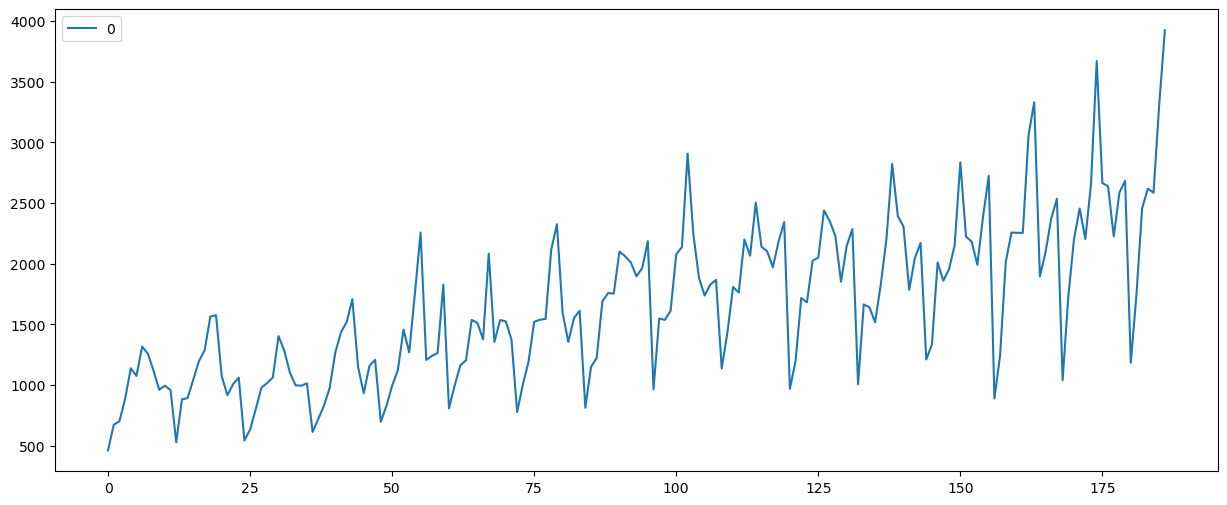

In [3]:
# %%
# Carregar dados
# A primeira etapa do processo é carregar os dados de um arquivo de texto
# Esta função retorna um dataframe do pandas que contém a série temporal
df = load_data('redwine.txt')

# Verificar tipos de dados
# É importante verificar os tipos de dados para evitar problemas futuros durante a análise
# Aqui, estamos imprimindo os tipos de dados das colunas do dataframe
print(df.dtypes)

# Plotar dados
# A visualização dos dados é uma parte crucial da análise de séries temporais
# Ao plotar os dados, podemos identificar padrões visuais, tendências, sazonalidades e possíveis outliers
plot_data(df)

In [4]:
# Testar a estacionariedade
# A maioria dos modelos de séries temporais requer que a série seja estacionária
# Uma série é estacionária se suas propriedades estatísticas, como média e variância, permanecerem constantes ao longo do tempo
# Aqui, usamos o teste ADF (Augmented Dickey-Fuller) para testar a estacionariedade da série
test_stationarity(df)

ADF Statistic: 0.9325860421378595
p-value: 0.9935011829238276
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576
Os dados não são estacionários.


<Axes: >

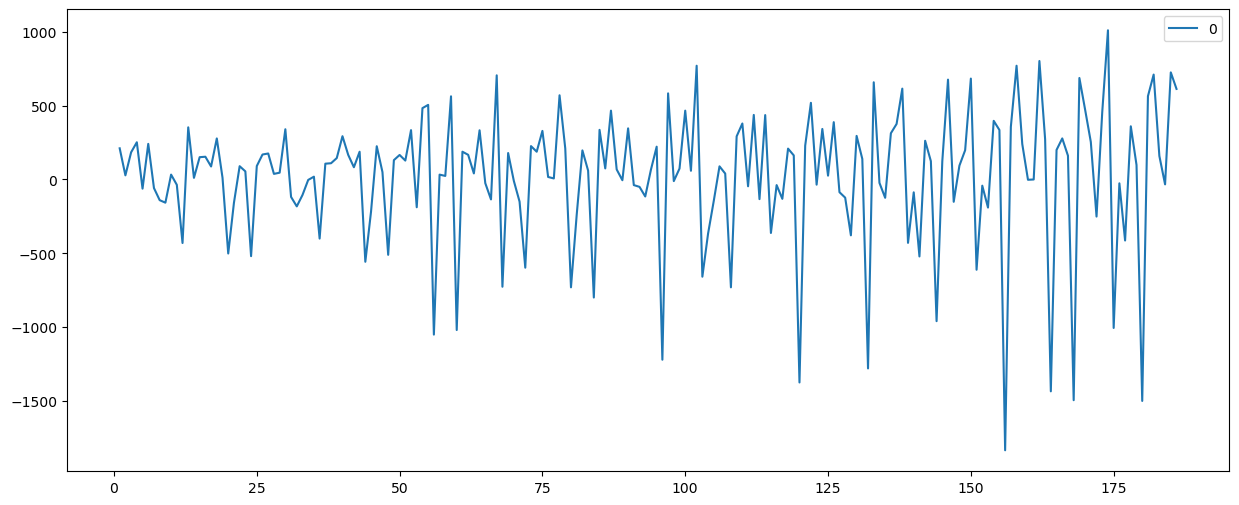

In [5]:
#Como o dado não é estacionário é feita a diferenciação para torná-lo estacionário	
df_diff = df.diff().dropna()
df_diff.plot()

In [6]:
# Testar a estacionariedade novamente
test_stationarity(df_diff)

ADF Statistic: -17.7456275267172
p-value: 3.387258160905648e-30
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576
Os dados são estacionários.


In [7]:
# Normalizar dados
# A normalização é uma técnica de pré-processamento que transforma os valores da série temporal em um intervalo específico (geralmente de 0 a 1)
# Isso é especialmente útil para algoritmos que não lidam bem com valores numéricos de grande escala
y = df.values
train_len = len(y) - 12  # Supondo que queremos deixar as últimas 12 observações para testes
y_normalized = normalize_data(y, train_len)

In [8]:
# Dividir os dados em conjuntos de treino e teste
# A divisão dos dados em treino e teste é uma prática comum no aprendizado de máquina
# O conjunto de treino é usado para treinar o modelo e o conjunto de teste é usado para avaliar seu desempenho
y_train, y_test = split_data(y_normalized, train_len)
print (y_train.shape[0])
print (y_test.shape[0])

175
12


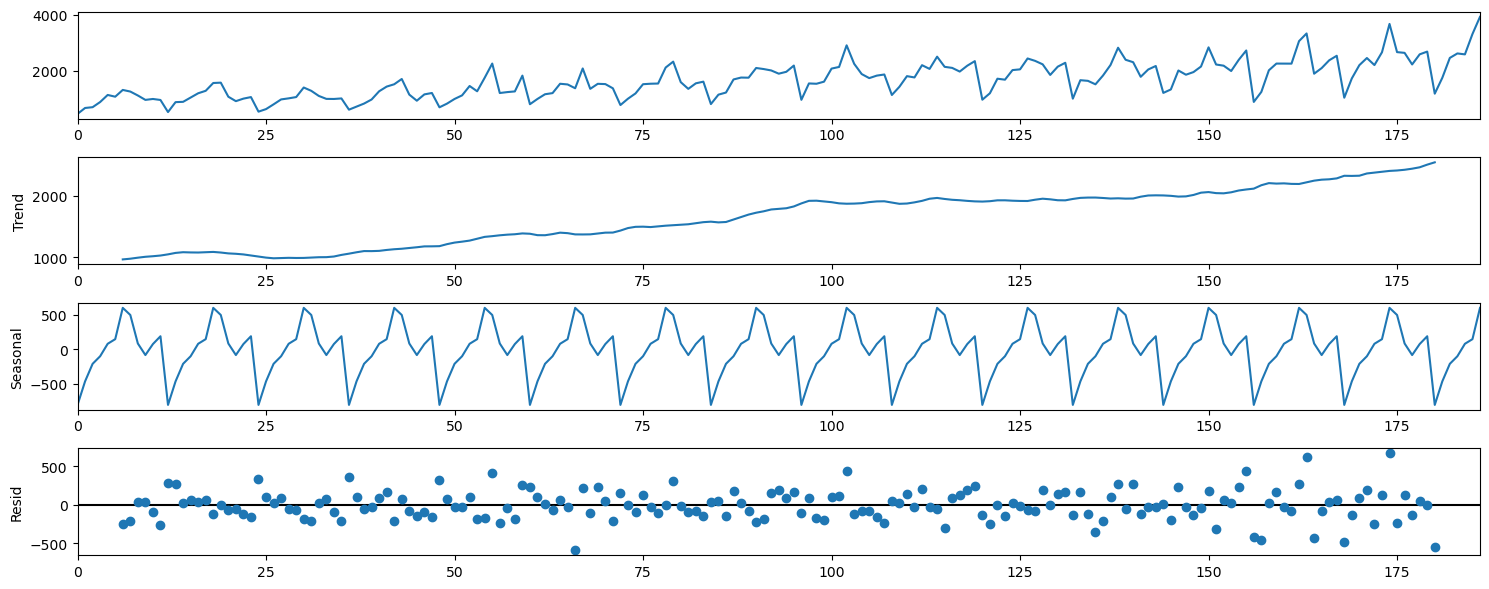

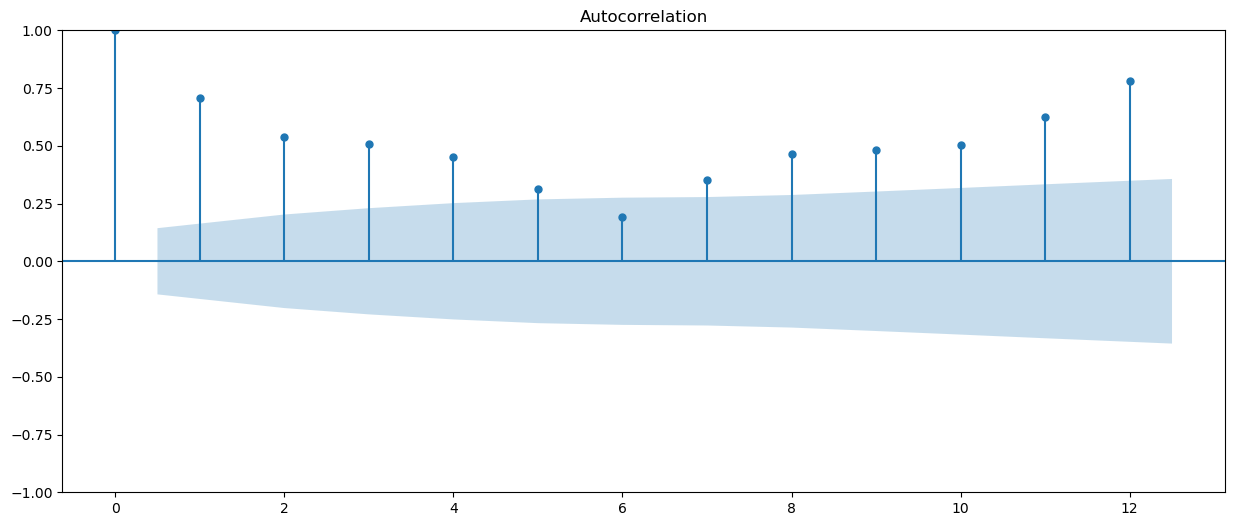

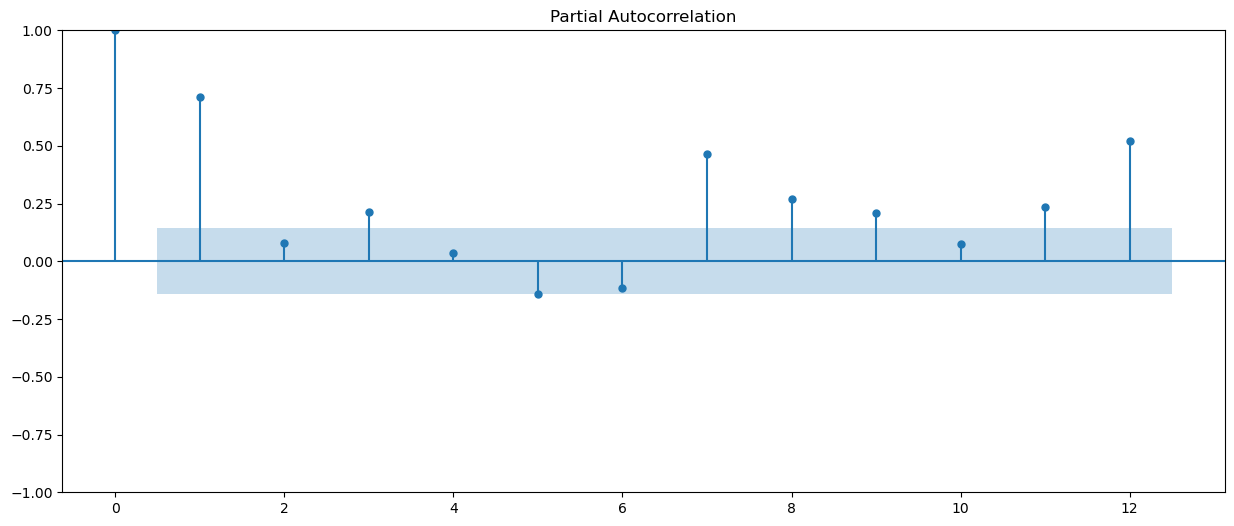

In [14]:
# Decompor a série temporal
# A decomposição de uma série temporal nos permite identificar seus componentes: tendência, sazonalidade e resíduo
# A tendência mostra a direção geral da série ao longo do tempo
# A sazonalidade mostra padrões regulares e previsíveis que se repetem em intervalos fixos de tempo
# O resíduo é a parte da série que não pode ser explicada pela tendência ou sazonalidade
decompose_ts(df)

# Plotar ACF e PACF
# As funções de autocorrelação (ACF) e autocorrelação parcial (PACF) são úteis para identificar a natureza dos dados
# A ACF mostra a correlação de uma série com seus próprios lags
# A PACF mostra a correlação de uma série com seus próprios lags, mas depois de remover as correlações já explicadas pelos lags intermediários
plot_acf_pacf(df)

Test MSE: 0.0385971063
Test MAE: 0.1689857972


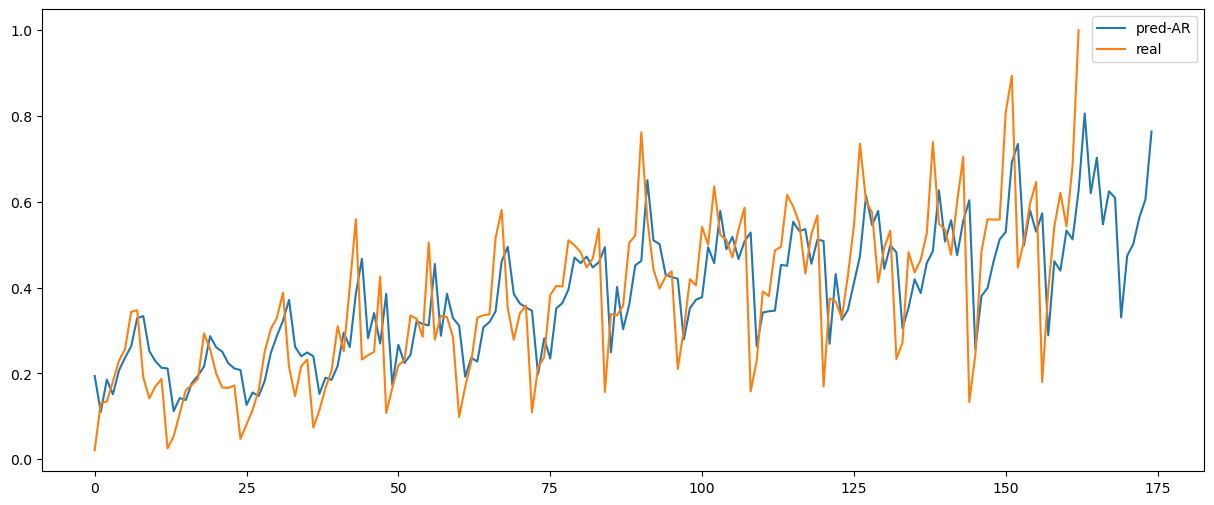

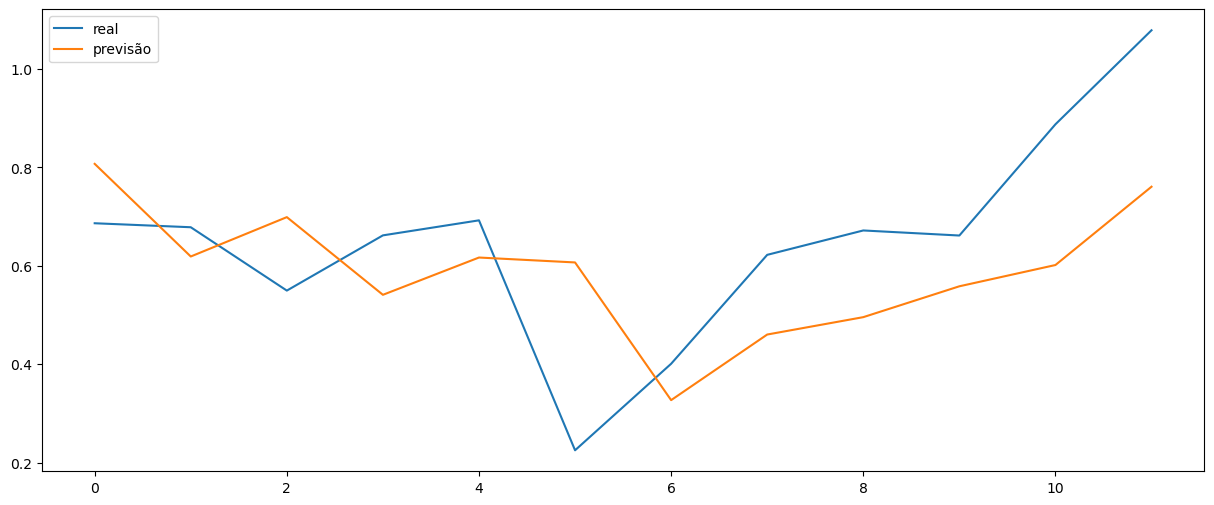

In [17]:
# Treinar o modelo AR
# Neste passo, treinamos um modelo AR em nosso conjunto de treinamento
model_ar = pm.arima.ARIMA(order=(3,0,0))  
model_ar = train_model(model_ar, y_train)

# Fazer previsões usando o modelo
# Após o treinamento, utilizamos o modelo para fazer previsões no conjunto de teste
# Isso nos permite avaliar o desempenho do modelo em dados que não foram usados durante o treinamento
forecasts = predict(model_ar, y_test)

m=12

predictions_train_AR = model_ar.predict_in_sample()
plt.plot(predictions_train_AR[m:], label='pred-AR')
plt.plot(y_train[m:], label='real')
plt.legend()

# Avaliar o modelo
# Neste passo, comparamos as previsões do modelo com os valores reais para avaliar o desempenho do modelo
# As métricas comuns para avaliar a precisão das previsões de séries temporais incluem erro médio absoluto (MAE), erro quadrático médio (MSE) e raiz do erro quadrático médio (RMSE)
evaluate_model(y_test, forecasts)

# Plotar as previsões
# A visualização das previsões em relação aos valores reais nos ajuda a entender o desempenho do modelo de uma maneira mais intuitiva
# Podemos visualmente identificar onde o modelo performou bem e onde não conseguiu capturar com precisão a variação na série temporal
plot_forecasts(y_test, forecasts)

Test MSE: 0.0515796404
Test MAE: 0.1983132974


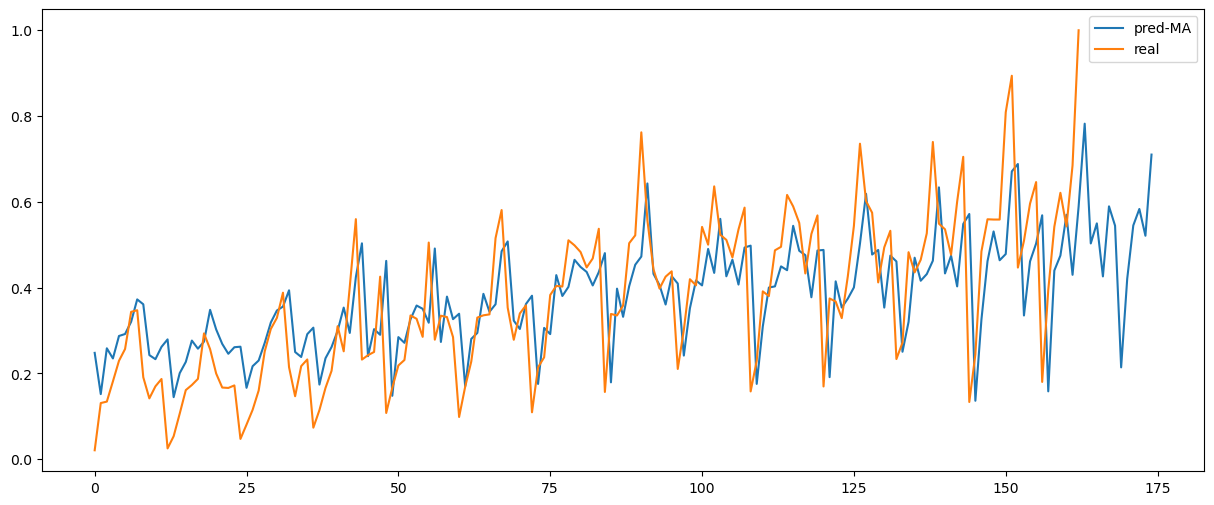

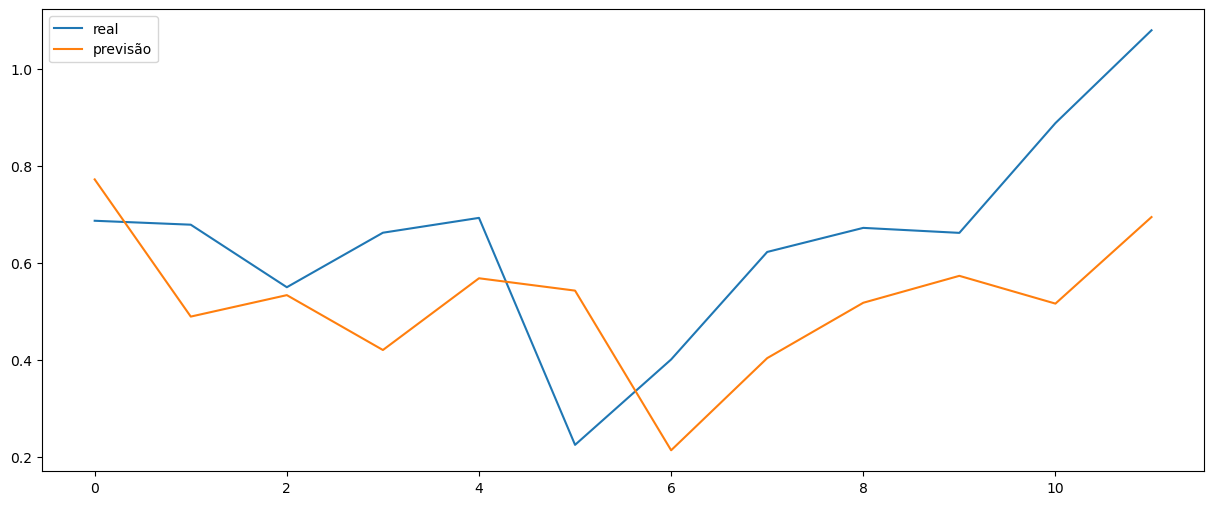

In [18]:
# Treinar o modelo MA
# Neste passo, treinamos um modelo MA em nosso conjunto de treinamento
model_ma = pm.arima.ARIMA(order=(0,0,3))  
model_ma = train_model(model_ma, y_train)

# Fazer previsões usando o modelo
# Após o treinamento, utilizamos o modelo para fazer previsões no conjunto de teste
# Isso nos permite avaliar o desempenho do modelo em dados que não foram usados durante o treinamento
forecasts = predict(model_ma, y_test)

m=12

predictions_train_MA = model_ma.predict_in_sample()
plt.plot(predictions_train_MA[m:], label='pred-MA')
plt.plot(y_train[m:], label='real')
plt.legend()

# Avaliar o modelo
# Neste passo, comparamos as previsões do modelo com os valores reais para avaliar o desempenho do modelo
# As métricas comuns para avaliar a precisão das previsões de séries temporais incluem erro médio absoluto (MAE), erro quadrático médio (MSE) e raiz do erro quadrático médio (RMSE)
evaluate_model(y_test, forecasts)

# Plotar as previsões
# A visualização das previsões em relação aos valores reais nos ajuda a entender o desempenho do modelo de uma maneira mais intuitiva
# Podemos visualmente identificar onde o modelo performou bem e onde não conseguiu capturar com precisão a variação na série temporal
plot_forecasts(y_test, forecasts)

Test MSE: 0.0327290423
Test MAE: 0.1315020103


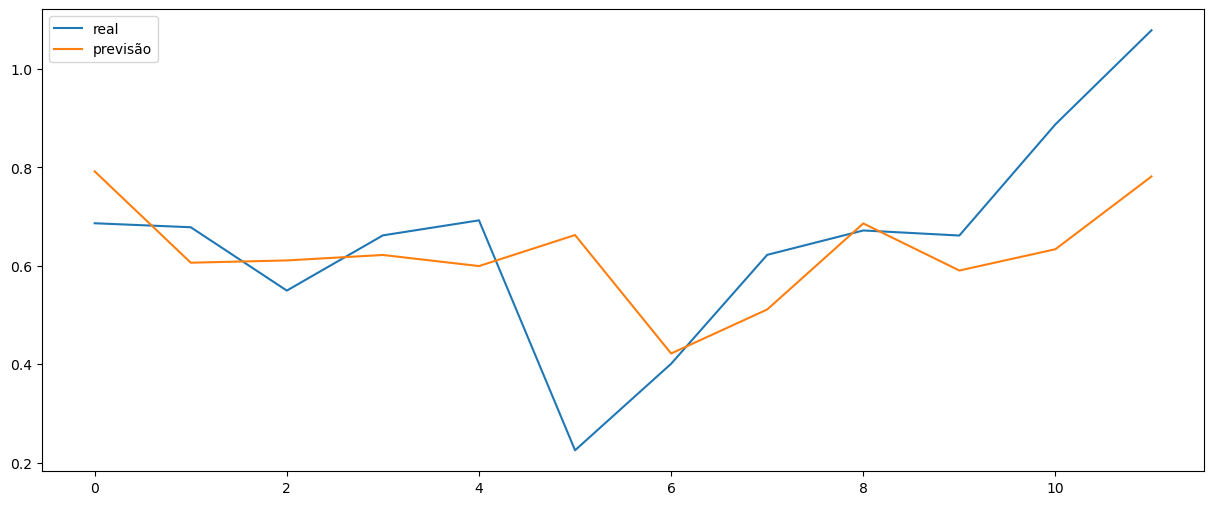

In [12]:
# Treinar o modelo ARIMA
# Neste passo, treinamos um modelo ARIMA em nosso conjunto de treinamento
model_ma = pm.arima.ARIMA(order=(3,1,3))  
model_ma = train_model(model_ma, y_train)

# Fazer previsões usando o modelo
# Após o treinamento, utilizamos o modelo para fazer previsões no conjunto de teste
# Isso nos permite avaliar o desempenho do modelo em dados que não foram usados durante o treinamento
forecasts = predict(model_ma, y_test)

# Avaliar o modelo
# Neste passo, comparamos as previsões do modelo com os valores reais para avaliar o desempenho do modelo
# As métricas comuns para avaliar a precisão das previsões de séries temporais incluem erro médio absoluto (MAE), erro quadrático médio (MSE) e raiz do erro quadrático médio (RMSE)
evaluate_model(y_test, forecasts)

# Plotar as previsões
# A visualização das previsões em relação aos valores reais nos ajuda a entender o desempenho do modelo de uma maneira mais intuitiva
# Podemos visualmente identificar onde o modelo performou bem e onde não conseguiu capturar com precisão a variação na série temporal
plot_forecasts(y_test, forecasts)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-190.722, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-196.494, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-204.466, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-192.421, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-205.848, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-227.880, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-198.092, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-210.117, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-227.585, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-228.181, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-227.337, T

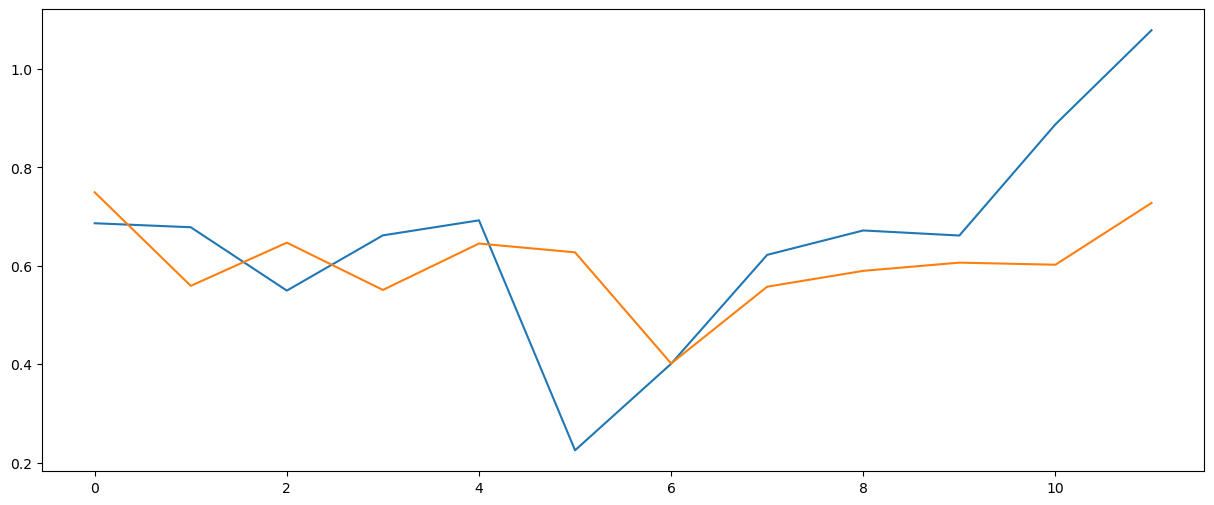

In [19]:
# Função para treinar o modelo Auto ARIMA
def train_auto_arima_model(df_diff, y_train, m):
    model_AutoARIMA = pm.AutoARIMA(trace=True, suppress_warnings=True, max_p=10, stepwise=True, seasonal=False, m=m)
    model_AutoARIMA.fit(y_train)
    return model_AutoARIMA

# Função para fazer previsões usando o modelo
def predict_auto_arima_model(model_AutoARIMA, y_test):
    def forecast_one_step():
        fc = model_AutoARIMA.predict(n_periods=1, return_conf_int=False)
        return fc.tolist()[0]
    forecasts_auto_ARIMA = []
    for new_ob in y_test:
        fc = forecast_one_step()
        forecasts_auto_ARIMA.append(fc)
        model_AutoARIMA.update(new_ob)
    return forecasts_auto_ARIMA

# Função para avaliar o modelo
def evaluate_auto_arima_model(y_test, forecasts_auto_ARIMA):
    print("Test MSE: %.10f" % mse(y_test, forecasts_auto_ARIMA))
    print("Test MAE: %.10f" % mae(y_test, forecasts_auto_ARIMA))

# Função para plotar as previsões
def plot_auto_arima_forecasts(y_test, forecasts_auto_ARIMA):
    plt.plot(y_test)
    plt.plot(forecasts_auto_ARIMA)

# Treine o modelo Auto ARIMA
model_AutoARIMA = train_auto_arima_model(df_diff, y_train, m=12)

# Faça previsões usando o modelo
forecasts_auto_ARIMA = predict_auto_arima_model(model_AutoARIMA, y_test)

# Avalie o modelo
evaluate_auto_arima_model(y_test, forecasts_auto_ARIMA)

# Plote as previsões
plot_auto_arima_forecasts(y_test, forecasts_auto_ARIMA)
